In [1]:
#| default_exp learner_with_stacktrace

# Callbacks as generators + pylance support
Here is a possible implementation of Callback system that:
- let us use %debug to inspect every executed callback with all its local variables in case an exception was raised,
- has minimal changes to the current Callback system, as it is as well based on generators,
- adds pylance support (current notebook has 0 issues detected, compared to 60+),
- removes circular dependency on learner in callbacks allowing learner to use reference counting for deallocation.

## Setup

In [29]:
#Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
# seams to be issue not only related to torchaudio https://github.com/pytorch/pytorch/issues/46409
%env OMP_NUM_THREADS=1

env: OMP_NUM_THREADS=1


In [30]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager
from warnings import warn

from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from datasets import load_dataset,load_dataset_builder # type: ignore
from miniai.datasets import *
from miniai.conv import *

from fastprogress import progress_bar,master_bar

In [31]:
# Init from 09_learner.ipynb
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)
from torcheval.metrics import MulticlassAccuracy,Mean
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)
@inplace
def transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]
bs = 1024
tds = dsd.with_transform(transformi) # type: ignore
from miniai.learner import *
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb,yb = next(iter(dt))
m,nh = 28*28,50
def get_model(): return nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

  0%|          | 0/2 [00:00<?, ?it/s]

## New callbacks
I figure out a way to achieve this with minimal changes to the current `Callbacks`, 
I'm using `yield from`  as a way to pass the execution flow retaining function on the stack.
Callback looks like this now:

```python
class CompletionCB(CallbackBase):
    def fit(self, learn):
        # former before_fit method
        self.count = 0 
        yield from super().fit(learn) # passes execution to the next callback
        # former after_fit method
        print(f'Completed {self.count} batches')
    def batch(self, learn): 
        yield from super().batch(learn) 
        # former after_batch method 
        self.count += 1
```

The use of yield from creates a nice stacktrace if we properly use `Generator.throw` to put in an exception catched in
the `callback_ctx` context manager. Below minimal example that shows how it works in python
For more experiments see [09_callback_stack.ipynb](09_callback_stack.ipynb)

In [2]:
def cb1(**kwargs):
    print('before cb1')
    yield from cb2(**kwargs)
    print('after cb1')
def cb2(**kwargs):
    print('before cb2')
    yield 1
    print('after cb2')

gen = cb1()
next(gen)
gen.throw(Exception('test'))

before cb1
before cb2


Exception: test

In [3]:
def cb1(**kwargs):
    print('before cb1')
    yield next(cb2(**kwargs))
    print('after cb1')
def cb2(**kwargs):
    print('before cb2')
    yield 1
    print('after cb2')

gen = cb1()
next(gen)
gen.throw(Exception('test'))

before cb1
before cb2


Exception: test






### How yield from works to form a stacktrace in case of exception

In [32]:
def cb1(set_val=None,**kwargs):
    print('before cb1')
    if set_val is not None: kwargs['val']=set_val
    yield from cb2(**kwargs)
    print('after cb1')

def cb2(throw_in_chain=False, **kwargs):
    print('before cb2')
    if throw_in_chain: raise Exception('error')
    yield from end_of_chain(**kwargs)
    print('after cb2')

def end_of_chain(val, **kwargs):
    print(f'before yield {val} - Finishing a chain by yielding None')
    yield val
    print(f'after yield {val}')

import traceback
@contextmanager
def context(**kwargs):
    gen = cb1(val=1, **kwargs) # callback not yet executed
    print("before any callbacks", gen)
    try:
        yield from gen # this executes the 'before' callbacks then body of with and then the 'after' callbacks
    except Exception as e:
        gen.throw(RuntimeError, e, e.__traceback__) # I need to change the exception type so that the traceback is not cut
        list(gen) # this finish the chain of callbacks
        
with context() as val:
    print('>>> body of the with statement') 
    print(1/val)


before any callbacks <generator object cb1 at 0x1509c2180>
before cb1
before cb2
before yield 1 - Finishing a chain by yielding None
>>> body of the with statement
1.0
after yield 1
after cb2
after cb1


In [33]:
with context(set_val=0) as val:
    print('>>> Body of the with statement')
    print('>>> + exception')
    print(1/val)

before any callbacks <generator object cb1 at 0x1509c21f0>
before cb1
before cb2
before yield 0 - Finishing a chain by yielding None
>>> Body of the with statement
>>> + exception


RuntimeError: division by zero

In [ ]:
%debug

> /var/folders/f2/nlr2kz4j2q542b5xz6z640500000gn/T/ipykernel_60935/154339608.py(4)<module>()
      1 with context(set_val=0) as val:
      2     print('>>> Body of the with statement')
      3     print('>>> + exception')
----> 4     print(1/val)

0
> /var/folders/f2/nlr2kz4j2q542b5xz6z640500000gn/T/ipykernel_60935/2020174593.py(15)end_of_chain()
     13 def end_of_chain(val, **kwargs):
     14     print(f'before yield {val} - Finishing a chain by yielding None')
---> 15     yield val
     16     print(f'after yield {val}')
     17 

> /var/folders/f2/nlr2kz4j2q542b5xz6z640500000gn/T/ipykernel_60935/2020174593.py(10)cb2()
      8     print('before cb2')
      9     if throw_in_chain: raise Exception('error')
---> 10     yield from end_of_chain(**kwargs)
     11     print('after cb2')
     12 

{'val': 0}
> /var/folders/f2/nlr2kz4j2q542b5xz6z640500000gn/T/ipykernel_60935/2020174593.py(4)cb1()
      2     print('before cb1')
      3     if set_val is not None: kwargs['val']=set_val
---->

### Callbacks chain implementation

In [34]:
import typing
import dataclasses

In [35]:
TrainCB().predict.__self__

Note that the control flow exceptions like `CancelEpochException` are put on coresponding
methods as `epoch.CancelException`. It let us avoid accessing `globals` via string names.
And it is handy to cancel execution as you can simply type `raise super().epoch.CancelException()`

In [36]:
def cb_wrapper(f):
    name  = f.__name__
    def _inner(*args, **kwargs):
        gen = f(*args, **kwargs)
        if gen is None: 
            return getattr(super(type(f.__self__), f.__self__), name)(*args, **kwargs)
        return gen
    return _inner

class EndOfCallbackChain():
    def end(self, learn): yield None
    def __getattr__(self, name): return self.end
    
class CallbackBase():
    order = 0
    next:typing.Union[EndOfCallbackChain,'CallbackBase'] = EndOfCallbackChain()
    def fit(self, learn): yield from cb_wrapper(self.next.fit)(learn)
    def epoch(self, learn): yield from cb_wrapper(self.next.epoch)(learn)
    def batch(self, learn): yield from cb_wrapper(self.next.batch)(learn)
    def predict(self, learn): self.next.predict(learn)
    def get_loss(self, learn): self.next.get_loss(learn)
    def backward(self, learn): self.next.backward(learn)
    def step(self, learn): self.next.step(learn)
    def zero_grad(self, learn): self.next.zero_grad(learn)

class CallbackChain(CallbackBase):
    def __init__(self, cbs):
        cbs = sorted(cbs, key=attrgetter('order'))
        n = EndOfCallbackChain()
        for cb in reversed(cbs): cb.next, n = n, cb
        self.next = n

In [37]:
class BrokenCallback(CallbackBase):
    order=100
    def fit(self, learn): 
        print("before_fit action, without yield")
cb = CallbackChain([BrokenCallback(), BrokenCallback()])
list(cb.fit(None))

before_fit action, without yield
before_fit action, without yield


[None]

In [38]:
@dataclasses.dataclass
class OldCBAdapter(CallbackBase):
    old_cb:Callback
    def as_gen(self, name, learn): 
        getattr(self.old_cb,f'before_{name}', id)(learn)    
        yield from super().fit(learn)
        getattr(self.old_cb,f'after_{name}', id)(learn)   

    def __getattribute__(self, name): 
        if name in ('fit','epoch','batch'): 
            p = partial(self.as_gen, name)
            p.__name__ = name
            return p
        if name in ('predict','get_loss','backward','step','zero_grad'): return getattr(self.old_cb, name)
        return object.__getattribute__(self, name)
    @classmethod
    def wrap_if_old(cls, cb): 
        if isinstance(cb, Callback): return cls(cb)
        return cb

In [39]:
class TestOldCB(Callback):
    def before_fit(self, learn): print('before_fit action')
    def after_fit(self, learn): print('after_fit action')
    def before_epoch(self, learn): print('before_epoch action')
    def after_epoch(self, learn): print('after_epoch action')
    def before_batch(self, learn): print('before_batch action')
    def after_batch(self, learn): print('after_batch action')

cb = OldCBAdapter(TestOldCB())
list(cb.fit(None))

before_fit action
after_fit action


[None]

In [40]:
class CallbackChain(CallbackBase):
    def __init__(self, cbs):
        cbs = sorted(map(OldCBAdapter.wrap_if_old, cbs), key=attrgetter('order'))
        n = EndOfCallbackChain()
        for cb in reversed(cbs): cb.next, n = n, cb
        self.next = n

In [41]:
cb = CallbackChain([TestOldCB(), BrokenCallback()])
list(cb.fit(None))

before_fit action
before_fit action, without yield
after_fit action


[None]

End to end callback test with way to execute it

In [42]:
class CompletionCB(CallbackBase):
    def fit(self, *_):
        self.count = 0
        yield from super().fit(*_)
        print(f'Completed {self.count} batches')
    def batch(self, *_): 
        yield from super().batch(*_)
        self.count += 1

In [43]:
cb = CompletionCB()
fit_cb = cb.fit(None) # nothing is run yet
next(fit_cb) # next/send(None) run the before_fit
for i in range(3): list(cb.batch(None)) # list run the before and after batch
list(fit_cb); # run the after_fit. Using `list`` instead of `next` to avoid the StopIteration exception

Completed 3 batches


## Learner with new callbacks + support for pylance / type checkers

Since I was changing the learner I also added support for pylance type checking. It is not a big deal, but it is nice to have.
This notebook could have 0 issues detected if few functions would define type unions like to_device, to_cpu etc.
The original notebook has 60 issues detected by pylance.
I've did so by replacing `setattr` with `@dataclass`, and introduction of execution context (`learn.learn`)
which stores variables produced during `fit` call, that previously landed on learn. 
Now the variables are part of learn.learn, and we can be easily passed between callbacks.

I also enabled reference counting by adding `weakref` to `learn`, to free GPU memory instantly once learner goes out of scope.

The learner code is about the same size as original one. I've put in the learner `TrainCB` to avoid complication in callbacksystem, as it seems this might be better off done via inheritance, which can be dynamically added in the future if needed.

In [44]:
import dataclasses
import weakref

In [57]:
#|export
@dataclasses.dataclass # instead of setattr so pylance can see the fields
class Learner:
    model: nn.Module; dls: DataLoaders; loss_func: typing.Callable; lr: float|torch.Tensor; cbs: typing.Sequence[CallbackBase]
    opt_func = optim.SGD
    def __post_init__(self): self.cb_chain = CallbackChain(self.cbs)

    @contextmanager
    def callback_ctx(self, cb_attr):
        nm = cb_attr.__name__
        callbacks = getattr(self.cb_chain, nm)(self)
        try:
            yield from callbacks
        except globals()[f'Cancel{nm.title()}Exception']: list(callbacks) # do the after callbacks
        except Exception as e:
            if e.__traceback__.tb_next is None: raise # type: ignore , not sure why it complains here
            callbacks.throw(RuntimeError, e, e.__traceback__) # To make the exception appear in chain of callbacks

    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        with self.callback_ctx(CallbackBase.epoch):
            for self.iter, self.batch in enumerate(self.dl):
                with self.callback_ctx(CallbackBase.batch):
                    self.predict()
                    self.get_loss()
                    if self.model.training:
                        self.backward()
                        self.step()
                        self.zero_grad()
    
    def fit(self, n_epochs):
        self.n_epochs = n_epochs
        self.epochs = range(n_epochs)
        self.opt = self.opt_func(self.model.parameters(), self.lr) # type: ignore , opt_func has wrong param type inferred
        with self.callback_ctx(CallbackBase.fit):
            for self.epoch in self.epochs:
                self.one_epoch(True)
                with torch.no_grad(): self.one_epoch(False)

    def reset(self): self.clear()

    def __getattr__(self, name):
        if name in ('predict','get_loss','backward','step','zero_grad'): return partial(getattr(self.cb_chain, name), self)
        raise AttributeError(name)


class TrainCB(CallbackBase):
    def predict(self, learn): learn.preds = learn.model(learn.batch[0])
    def get_loss(self, learn): learn.loss = learn.loss_func(learn.preds, learn.batch[1])
    def backward(self, learn): learn.loss.backward()
    def step(self, learn): learn.opt.step()
    def zero_grad(self, learn): learn.opt.zero_grad()


class TrainContext(dict): # to keep execution state in a dict instead of learner class
    _learn: weakref.ref['Learner']
    def __init__(self, learn: 'Learner'): self._learn = weakref.ref(learn)
    @property
    def learn(self): return self._learn()
    def __getattr__(self, k): # hasattr works
        try: return self[k] 
        except: raise AttributeError(k)
    def __setattr__(self, k: str, v: typing.Any) -> None:
        self[k]=v

In [58]:
class DeviceCB(CallbackBase):
    def __init__(self, device: str|torch.device = def_device): self.device = device
    def fit(self, learn): 
        learn.model.to(self.device)
        yield from super().fit(learn)
    
    def batch(self, learn): 
        learn.batch = to_device(learn.batch, device=self.device) # type: ignore , to_device has wrong param type inferred
        yield from super().batch(learn)

In [59]:
cbs = [DeviceCB('mps'),TrainCB()]
learn = Learner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

## The rest of callbacks

In [48]:
#|export
class MetricsCB(CallbackBase):
    def __init__(self, *ms, **metrics):
        for o in ms: metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()

    def _log(self, d): print(d)
    def fit(self, learn):
        learn.metrics = self
        yield from super().fit(learn)
    
    def epoch(self, learn): 
        for o in self.all_metrics.values(): o.reset() 
        yield from super().epoch(learn)
        log = {k:f'{v.compute():.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = learn.model.training
        self._log(log)

    def batch(self, learn):
        yield from super().batch(learn)
        x,y = to_cpu(learn.batch)
        for m in self.metrics.values(): m.update(to_cpu(learn.preds), y)
        self.loss.update(to_cpu(learn.loss), weight=len(x)) # type: ignore

In [49]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics]
learn = Learner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

{'accuracy': '0.614', 'loss': '1.166', 'epoch': 0, 'train': True}
{'accuracy': '0.690', 'loss': '0.833', 'epoch': 0, 'train': False}


In [56]:
#|export
class ProgressCB(CallbackBase):
    order = MetricsCB.order+1
    def __init__(self, plot: bool = False):  fc.store_attr()
    def fit(self, learn):
        print(self.plot2)
        print(self.plot)
        learn.epochs = self.mbar = master_bar(learn.epochs)
        if hasattr(learn, 'metrics'): learn.metrics._log = self._log
        self.losses = []
        yield from super().fit(learn)
    
    def _log(self, d): 
        if not getattr(self.mbar, 'lines', []): self.mbar.write(list(d), table=True) 
        self.mbar.write(list(d.values()), table=True)

    def epoch(self, learn): 
        learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)
        yield from super().epoch(learn)
    
    def batch(self, learn):
        yield from super().batch(learn)
        if not hasattr(learn, 'loss'): return
        learn.dl.comment = f'{learn.loss:.3f}'
        if self.plot and hasattr(learn, 'metrics') and learn.model.training:
            self.losses.append(learn.loss.item())
            self.mbar.update_graph([[fc.L.range(self.losses), self.losses]])

accuracy,loss,epoch,train
0.603,1.182,0,True
0.690,0.849,0,False


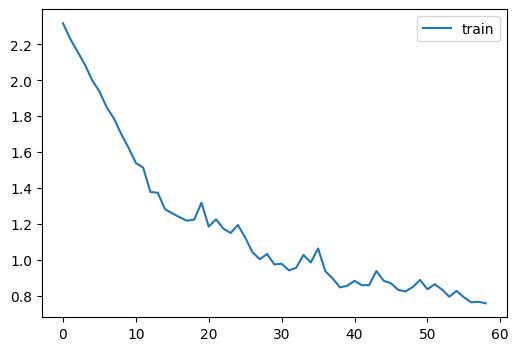

In [51]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]
learn = Learner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

## Stacktrace in action in full callback chain

In [53]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]
learn = Learner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

RuntimeError: preds